# Chapter 10 Validating and tuning

In [95]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import auc, make_scorer, mean_absolute_error,mean_squared_error, roc_curve, RocCurveDisplay
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from skopt.plots import plot_convergence, plot_objective
from skopt.space import Real, Integer
import xgboost as xgb

In [10]:
# Load data
DATA_PATH = "../data/raw/data_ml.csv"
data_ml = pd.read_csv(DATA_PATH)
data_ml['date'] = pd.to_datetime(data_ml['date'])
data_ml['R1M_Usd_C'] = (data_ml['R1M_Usd'] > 0).astype(int) # can be useful for classification tasks

In [43]:
# Recreate variables done in notebook_5_tree_based_methods.ipynb
X = data_ml.iloc[:,3:95] # recall features/predictors, full sample
y = data_ml['R1M_Usd'] # recall label/Dependent variable, full sample

features = X.columns.values.tolist()
features_short = ["Div_Yld", "Eps", "Mkt_Cap_12M_Usd", "Mom_11M_Usd", "Ocf", "Pb", "Vol1Y_Usd"]
separation_date = pd.to_datetime('2013-01-01')
training_sample = data_ml.loc[data_ml['date'] < separation_date]
testing_sample = data_ml.loc[data_ml['date'] > separation_date]

# Regression labels
y_train = training_sample['R1M_Usd'].values # regression target
X_train = training_sample[features]
X_test = testing_sample[features]
y_test = testing_sample['R1M_Usd'].values

# Classification labels: up (1) if return > 0 else 0
y_c_train = training_sample['R1M_Usd_C'].values # classification target
y_c_test = testing_sample['R1M_Usd_C'].values

# For XGBoost model training on extreme values only
separation_mask = data_ml['date'] < separation_date

data_ml['R1M_Usd_quantile'] = data_ml.groupby('date')['R1M_Usd'].transform(         # creating quantile... 
        lambda x: pd.qcut(x, 100, labels=False, duplicates=('drop'), precision=50)) # ...for selecting extreme values

boolean_quantile=(data_ml.loc[separation_mask]['R1M_Usd_quantile'].        # boolean array for selecting rows
                  values<=0.2) | (data_ml.loc[separation_mask]['R1M_Usd_quantile'].values>=0.8) # selecting extreme values

## 10.1 Learning metrics
### 10.1.2 Classification analysis

In [17]:
# Fit Random Forest Classifier
fit_RF_C = RandomForestClassifier( 
n_estimators = 40, # Nb of random trees
criterion ='gini', # function to measure the quality of a split
min_samples_split= 250, # Minimum size of terminal cluster
bootstrap=True, # replacement
max_features=30, # Nb of predictive variables for each tree
max_samples=30000 # Size of (random) sample for each tree
)
fit_RF_C=fit_RF_C.fit(X_train, y_c_train) # Fitting the model

hitratio = np.mean(fit_RF_C.predict(X_test) == y_c_test)
print(f'Hit Ratio: {hitratio}')

Hit Ratio: 0.5523955901726489


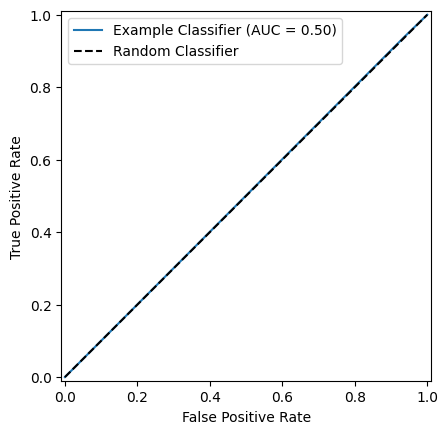

In [ ]:
fpr, tpr, thresholds = roc_curve(testing_sample['R1M_Usd_C'].values,
                                 fit_RF_C.predict(testing_sample[features]))
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, name='Example Classifier')
display.plot()
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.legend()
plt.show()

In [ ]:
print(f'AUC: {roc_auc}')

AUC: 0.5010576476311035


## 10.2 Validation
### 10.2.1 The variance-bias tradeoff: theory

In [ ]:
# Recreate variables from notebook_4_penalized_regressions.ipynb for Lasso and Ridge
y_penalized = data_ml['R1M_Usd'].values
X_penalized = data_ml[features].values
alphas = np.arange(1e-4,1.0e-3,1e-5) # here alpha is used for lambda in scikit-learn
lasso_res = {}
df_lasso_res = pd.DataFrame()

if df_lasso_res.empty:
  for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_penalized,y_penalized) 
    lasso_res[alpha] = lasso.coef_

  df_lasso_res = pd.DataFrame.from_dict(lasso_res).T # transpose the dataframe for plotting
  df_lasso_res.columns = features # adding the names of the factors
  predictors = (df_lasso_res.abs().sum() > 0.05) # selecting the most relevant


# df_lasso_res.loc[:,predictors].plot(xlabel='Lambda',ylabel='Beta',figsize=(12,6)); # plotting
n_alphas = 50
alphas = np.logspace(-2, 4, n_alphas) # transforming into log for Aspect ratio 
ridge_res = {}
for alpha in alphas:
  ridge = Ridge(alpha=alpha)
  ridge.fit(X_penalized,y_penalized)
  ridge_res[alpha] = ridge.coef_

df_ridge_res = pd.DataFrame.from_dict(ridge_res).T # transpose the dataframe for plotting
df_ridge_res.columns = features # adding the names of the factors
# df_ridge_res.loc[:,predictors].plot(xlabel='Lambda',ylabel='Beta',figsize=(15,5)); # plotting

array([<Axes: xlabel='Lambda'>, <Axes: xlabel='Lambda'>,
       <Axes: xlabel='Lambda'>], dtype=object)

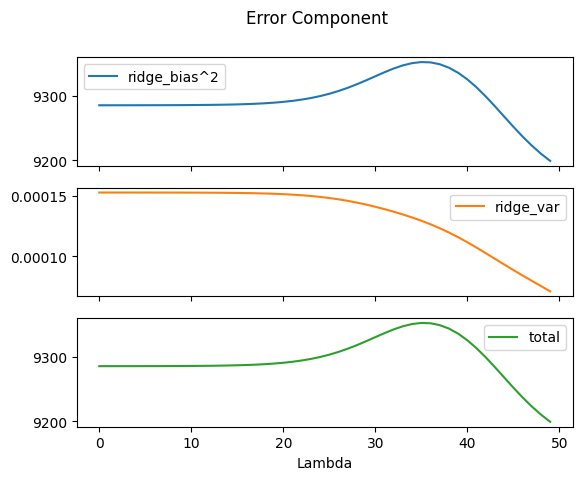

In [29]:
ridge_bias = []
ridge_var = []
for alpha in range(0,len(alphas),1):
    predictions=np.dot((df_ridge_res.iloc[alpha,:].values),X_penalized.T)
    ridge_bias.append(np.sum(np.square(predictions - y_penalized)))
    ridge_var.append(np.var(predictions))
df = pd.DataFrame(list(zip(ridge_bias, ridge_var)),
               columns =['ridge_bias^2', 'ridge_var'])
df['total']=df['ridge_bias^2']+df['ridge_var']
df.plot(subplots=True,title='Error Component',xlabel='Lambda')

### 10.2.2 The variance-bias tradeoff: illustration

In [51]:
# Recreate variables from notebook_5_tree_based_methods.ipynb
train_features_xgb=training_sample.loc[boolean_quantile,features_short] # Independent variables
train_label_xgb=training_sample.loc[boolean_quantile,'R1M_Usd'] # Dependent variable
train_matrix_xgb=xgb.DMatrix(train_features_xgb, label=train_label_xgb) # XGB format!

mono_const="(0, 0, -1, 1, 0, -1, 0)" # Initialize the vector -- "-1" == decreasing, "+1" increasing 
# Decreasing in market cap -- mono_const[2]
# Increasing in past return -- mono_const[3]
# Decreasing in price-to-book -- mono_const[5]

params = {
    # General Booster Parameters
    'booster' : 'dart',         # Explicitly set to DART to enable 'rate_drop'
    'objective' : "reg:squarederror", # Objective function
    'eta' : 0.3,               # Learning rate
    
    # Tree Structure and Pruning
    'max_depth' : 4,            # Max depth of each tree
    'gamma' : 0.1,              # Penalization of number of leaves (pruning).
    'lambda' : 1.0,             # L2 regularization on leaf weights (w^2)
    'monotone_constraints' : mono_const, # Monotonicity constraints

    # Subsampling/Regularization
    'subsample' : 0.6,          # Train on random 60% of sample
    'colsample_bytree' : 0.7,   # Train on random 70% of predictors

    # DART Specific Parameters
    'rate_drop' : 0.1,          # Dropout rate for DART
    'skip_drop' : 0.5,          # Probability of skipping the dropout procedure for DART
}

fit_xgb =xgb.train(params, train_matrix_xgb)

test_features_xgb=testing_sample[features_short] # Test sample => XGB format
test_matrix_xgb=xgb.DMatrix(test_features_xgb, label=y_test) # XGB format!

fit_xgb.predict(test_matrix_xgb)
mse = np.mean((fit_xgb.predict(test_matrix_xgb) - y_test)**2)
print(f'MSE: {mse}')

hitratio = np.mean(fit_xgb.predict(test_matrix_xgb) * y_test > 0)
print(f'Hit Ratio: {hitratio}')

MSE: 0.03387691083410983
Hit Ratio: 0.5575496336700025


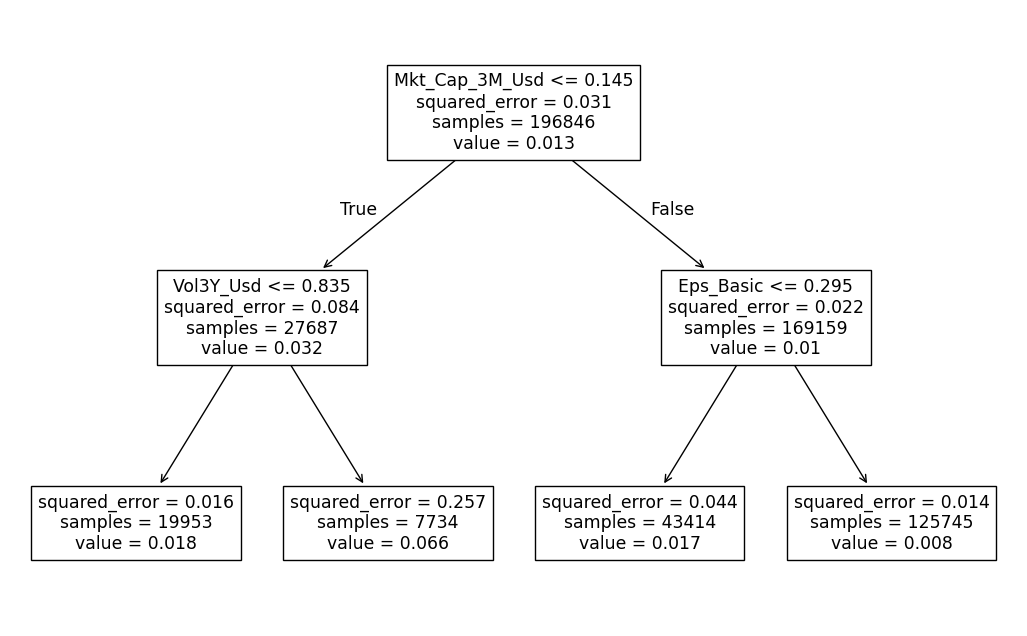

In [52]:
X = training_sample[features]
y = y_train

fit_tree_simple = tree.DecisionTreeRegressor(
  max_depth = 2, # Maximum depth (i.e. tree levels)
  ccp_alpha=0.000001, # complexity parameters
        )
fit_tree_simple.fit(X, y)
fig, ax = plt.subplots(figsize=(13, 8))
tree.plot_tree(fit_tree_simple,feature_names=X.columns.values, ax=ax)
plt.show()

In [53]:
bias_tree = np.mean(fit_tree_simple.predict(X_test) - y_test)
print(f'bias: {bias_tree}')

var_tree = np.var(fit_tree_simple.predict(X_test))
print(f'var: {var_tree}')

bias: 0.0022658076165167312
var: 0.00016769904555597237


In [54]:
bias_xgb = np.mean(fit_xgb.predict(test_matrix_xgb) - y_test)
print(f'bias: {bias_xgb}')

var_xgb = np.var(fit_xgb.predict(test_matrix_xgb))
print(f'var: {var_xgb}')

bias: 0.002319176982694935
var: 0.0004268623888492584


## 10.3 The search for good hyperparameters
### 10.3.2 Example: grid search

In [96]:
scorer = make_scorer(mean_absolute_error)
# A parameter grid for XGBoost
params = {
        'learning_rate': [0.1, 0.3, 0.5, 0.7, 0.9], # Values for eta
        'n_estimators': [10, 50, 100, 150],         # Values for nrounds (extended to match Bayes search space)
        'reg_lambda': [0.01, 0.1, 1, 10, 100] # Values for lambda
        }


In [97]:
model = xgb.XGBRegressor(max_depth=3, n_jobs=-1, objective='reg:squarederror', random_state=42)
model_gs = GridSearchCV(model, param_grid=params, cv=2, scoring='neg_mean_squared_error')
model_gs.fit(X_train, y_train)
cv_results = pd.DataFrame(model_gs.cv_results_)
print(f'Best Parameters using grid search: {model_gs.best_params_}')
print(f'Best Score (MSE): {-model_gs.best_score_}')


Best Parameters using grid search: {'learning_rate': 0.1, 'n_estimators': 10, 'reg_lambda': 100}
Best Score (MSE): 0.03068567048911503


IndexError: index 3 is out of bounds for axis 0 with size 3

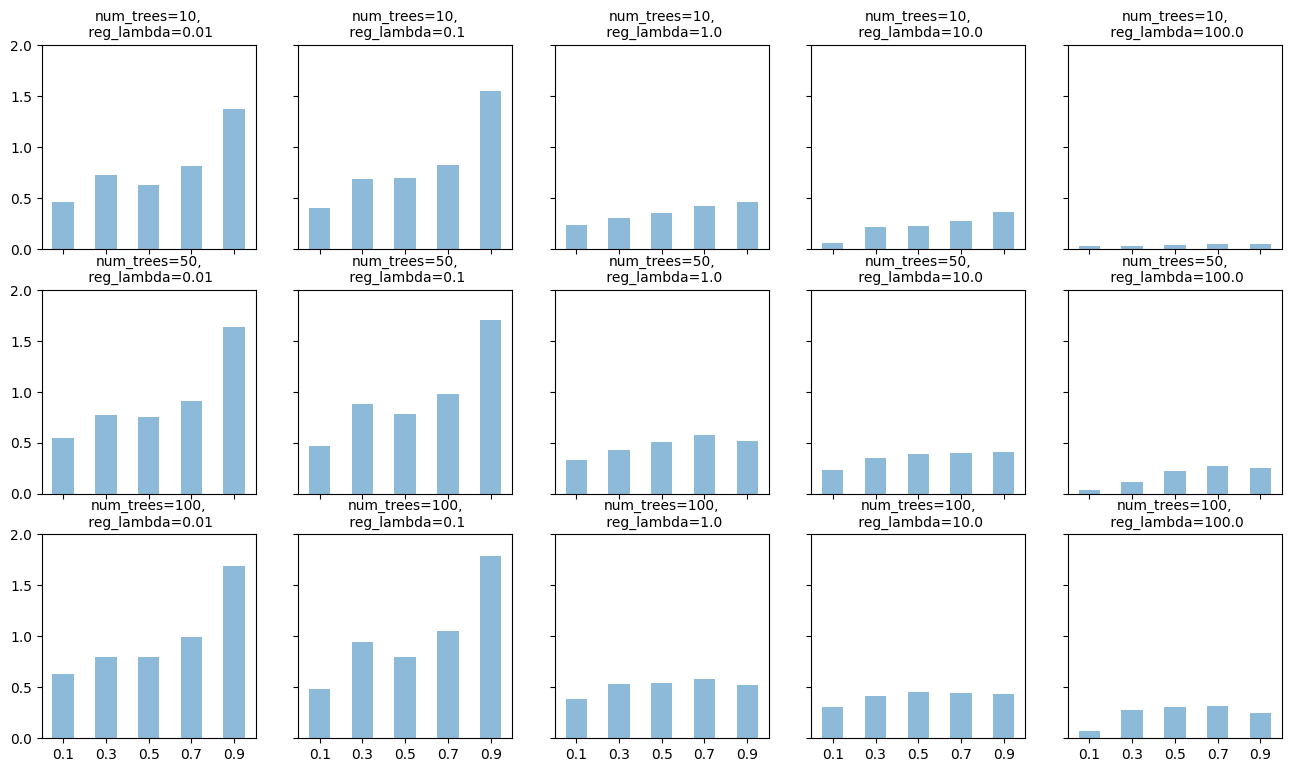

In [ ]:
res_df = pd.DataFrame(cv_results,
                      columns=["param_n_estimators","param_learning_rate","param_reg_lambda","mean_test_score"])
# Note, MAE is made negative in the scikit-learn library so that it can be maximized.
# As such, we can ignore the sign and assume all errors are positive.
res_df['mean_test_score'] = -res_df['mean_test_score'].values

# Build a grid sized to the number of parameter combinations
cols = 5
n_groups = len(res_df.groupby(["param_n_estimators", "param_reg_lambda"]))
rows = int(np.ceil(n_groups / cols))
fig, axes = plt.subplots(figsize=(16, 3*rows), nrows=rows, ncols=cols)
axes = np.atleast_2d(axes)

cnt = 0
for param, tmp in res_df.groupby(["param_n_estimators", "param_reg_lambda"]):
    ax = axes[cnt//cols][cnt%cols]
    np.round(tmp[["param_learning_rate","mean_test_score"]],2).plot.bar(
        ax=ax, x="param_learning_rate", y="mean_test_score", alpha=0.5, legend=None)
    ax.set_xlabel("")
    ax.set_ylim(0, 2)
    if cnt//cols < rows-1:
        ax.xaxis.set_ticklabels("")
    else:
        for label in ax.get_xticklabels():
            label.set_rotation(0)
    if cnt%cols > 0:
        ax.yaxis.set_ticklabels("")
    ax.set_title(f"num_trees={param[0]},\n reg_lambda={param[1]}", fontsize=10)
    cnt += 1

# Hide any unused axes
for extra in range(cnt, rows*cols):
    axes[extra//cols][extra%cols].axis('off')

plt.tight_layout()


### 10.3.3 Example: Bayesian optimization

In [ ]:
# Bayesian optimization search space defined with skopt.space objects to avoid duplicate points
search_spaces = {
    'learning_rate': Real(0.05, 0.9, prior='log-uniform'),
    'n_estimators': Integer(10, 150),
    'reg_lambda': Real(0.01, 100, prior='log-uniform')
}

opt = BayesSearchCV(
    estimator=model,
    search_spaces=search_spaces,
    scoring='neg_mean_squared_error',
    cv=2,
    n_iter=25,
    n_initial_points=10,
    random_state=42
)
opt.fit(X_train, y_train)
cv_results_opt = pd.DataFrame(opt.cv_results_)


d:\Code\ml-for-factor-investing\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.1), np.int64(10), np.int64(100)] before, using random point [0.3, 50, 100]
  warnings.warn(
d:\Code\ml-for-factor-investing\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.1), np.int64(10), np.int64(100)] before, using random point [0.5, 50, 10]
  warnings.warn(
d:\Code\ml-for-factor-investing\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.1), np.int64(10), np.int64(100)] before, using random point [0.7, 10, 0.1]
  warnings.warn(


In [ ]:
print(f'Best Parameters using bayes opt: {opt.best_params_}')
print(f'Best Score (MSE): {-opt.best_score_}')


Best Parameters using bayes opt: OrderedDict({'learning_rate': 0.1, 'n_estimators': 10, 'reg_lambda': 100})


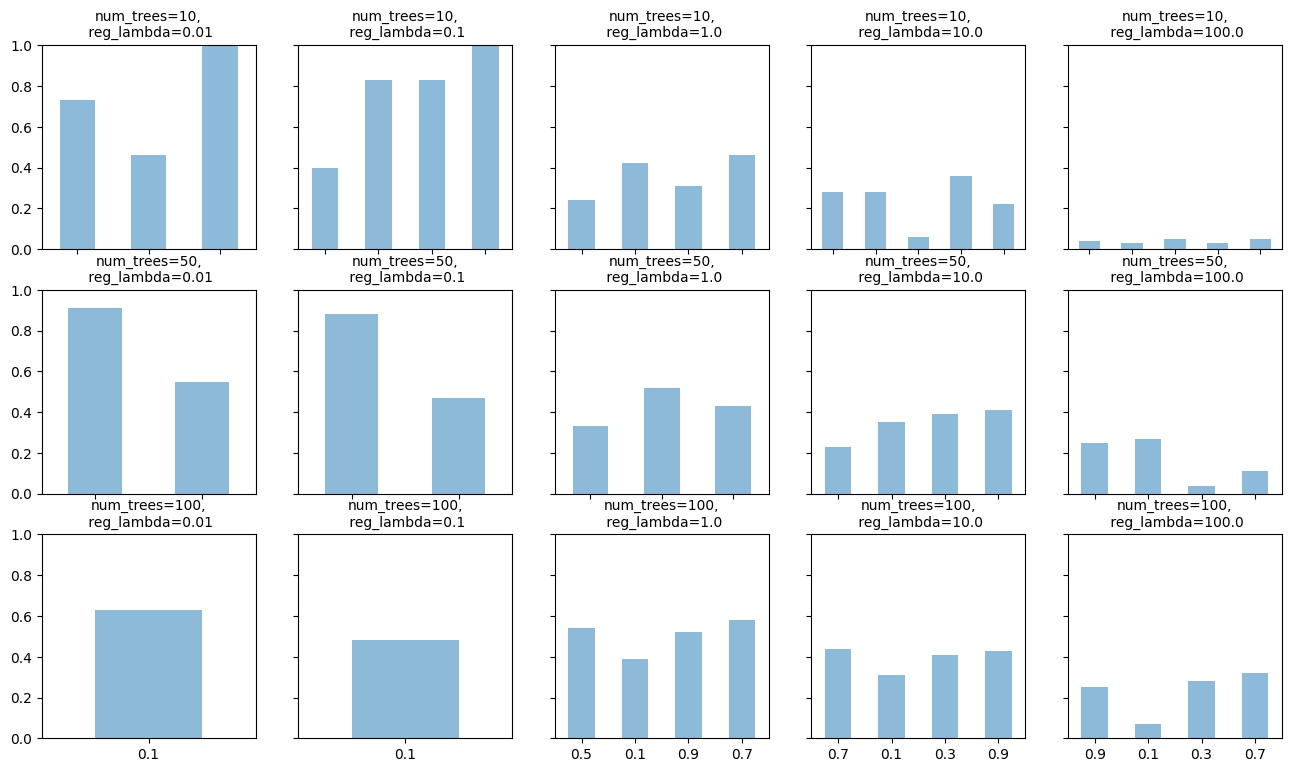

In [ ]:
res_df = pd.DataFrame(cv_results_opt,
                      columns=["param_n_estimators","param_learning_rate","param_reg_lambda","mean_test_score"])
# Note, MAE is made negative in the scikit-learn library so that it can be maximized.
# As such, we can ignore the sign and assume all errors are positive.
res_df['mean_test_score'] = -res_df['mean_test_score'].values

# Build a grid sized to the number of parameter combinations
cols = 5
n_groups = len(res_df.groupby(["param_n_estimators", "param_reg_lambda"]))
rows = int(np.ceil(n_groups / cols))
fig, axes = plt.subplots(figsize=(16, 3*rows), nrows=rows, ncols=cols)
axes = np.atleast_2d(axes)

cnt = 0
for param, tmp in res_df.groupby(["param_n_estimators", "param_reg_lambda"]):
    ax = axes[cnt//cols][cnt%cols]
    np.round(tmp[["param_learning_rate","mean_test_score"]],2).plot.bar(
        ax=ax, x="param_learning_rate", y="mean_test_score", alpha=0.5, legend=None)
    ax.set_xlabel("")
    ax.set_ylim(0, 1)
    if cnt//cols < rows-1:
        ax.xaxis.set_ticklabels("")
    else:
        for label in ax.get_xticklabels():
            label.set_rotation(0)
    if cnt%cols > 0:
        ax.yaxis.set_ticklabels("")
    ax.set_title(f"num_trees={param[0]},\n reg_lambda={param[1]:.2f}", fontsize=10)
    cnt += 1

# Hide any unused axes
for extra in range(cnt, rows*cols):
    axes[extra//cols][extra%cols].axis('off')

plt.tight_layout()


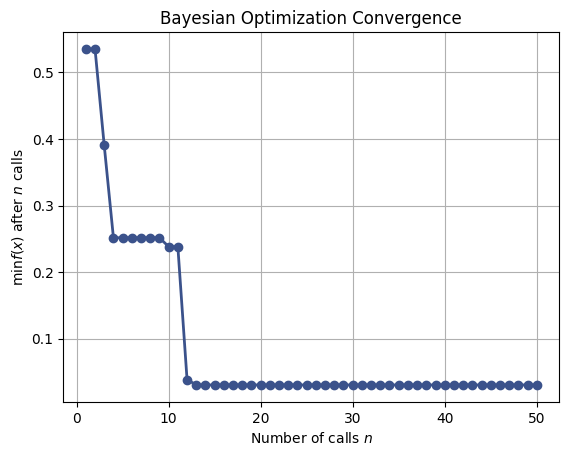

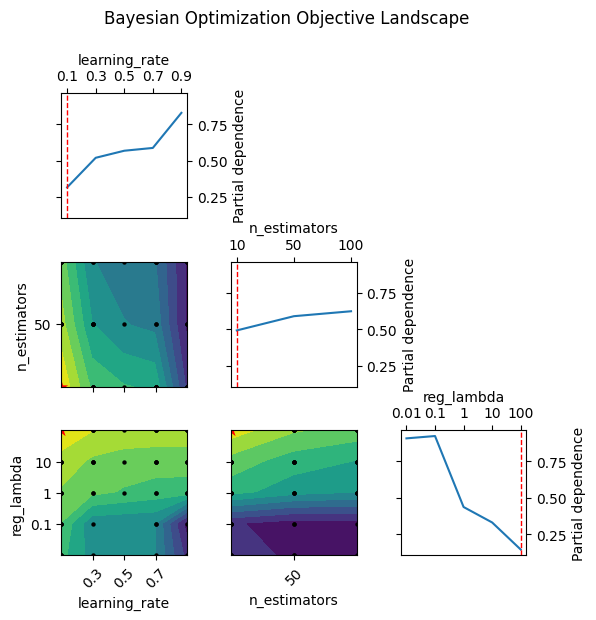

In [ ]:
# Visualize BayesSearchCV diagnostics
plot_convergence(opt.optimizer_results_[0])
plt.title('Bayesian Optimization Convergence')
plt.show()

plot_objective(opt.optimizer_results_[0])
plt.suptitle('Bayesian Optimization Objective Landscape', y=1.02)
plt.show()

# Optional: inspect sampled points
print(opt.optimizer_results_[0].x_iters)
print(opt.optimizer_results_[0].func_vals)
